In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

In [2]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:3


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch1/04703/sravula/UTAFSDataNew/new_data"
CHIP_NUM = 50

In [4]:
import utils

data_dict = utils.get_network_from_file(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['network', 'fmin', 'fmax', 'length', 'sweep', 'port_pairs'])

## Pre-process the data

In [6]:
data_net = data_dict['network']
data_freqs = data_dict['network'].frequency

In [7]:
print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

Frequency stats
Length: 9999
Spacing: 6.0012e+06
Start: 0.0000e+00
Stop: 6.0000e+10


In [8]:
f_start = data_freqs.start
f_step = data_freqs.step
good_spacing = (f_start / f_step).is_integer()
print("Can extrapolate without aliasing: ", good_spacing)

spacing = data_dict["sweep"]
print("SPACING: ", spacing)

good_chip = good_spacing and (spacing == "LINEAR")
print("GOOD SPACING!!!" if good_chip else "BAD SPACING???")

Can extrapolate without aliasing:  True
SPACING:  LINEAR
GOOD SPACING!!!


In [9]:
print([("%.4e" % s) for s in data_freqs.f[0:5]])

['0.0000e+00', '6.0012e+06', '1.2002e+07', '1.8004e+07', '2.4005e+07']


data_net = data_net.extrapolate_to_dc()
data_freqs = data_net.frequency 

print("Frequency stats")
print("Length: %d" % data_freqs.npoints)
print("Spacing: %.4e" % data_freqs.step)
print("Start: %.4e" % data_freqs.start)
print("Stop: %.4e" % data_freqs.stop)

print([("%.4e" % s) for s in data_freqs.f[0:5]])

## Make some variables we will need

In [10]:
def network_to_sparams(network):
    re_mat = network.s.real
    im_mat = network.s.imag
    out_mat = np.stack((re_mat, im_mat), axis=-1)

    out_sparams = utils.matrix_to_sparams(out_mat)

    return torch.from_numpy(out_sparams).view(-1, out_sparams.shape[-1]).unsqueeze(0)

In [11]:
N_FREQS = data_freqs.npoints
N_SPARAMS = int(data_net.nports * (data_net.nports + 1) / 2)

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  9999
N_SPARAMS:  78


In [12]:
x = network_to_sparams(data_net).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 156, 9999])


In [13]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 78, 9999])


## Grab Some Measurements

In [14]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
M = 0.1

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  9999
Number of Measurements:  999
Undersampling Ratio:  0.0999099909990999


In [15]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = data_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.npoints)

y shape:  torch.Size([1, 156, 999])
y_freqs shape:  999


In [16]:
y_mag = utils.sparams_to_mag(y)

print("y_mag shape: ", y_mag.shape)

y_mag shape:  torch.Size([1, 78, 999])


In [17]:
z = torch.clone(x)
z[:, :, missing_inds] = 0

print("z shape: ", z.shape)

z shape:  torch.Size([1, 156, 9999])


## Plot data and measurements

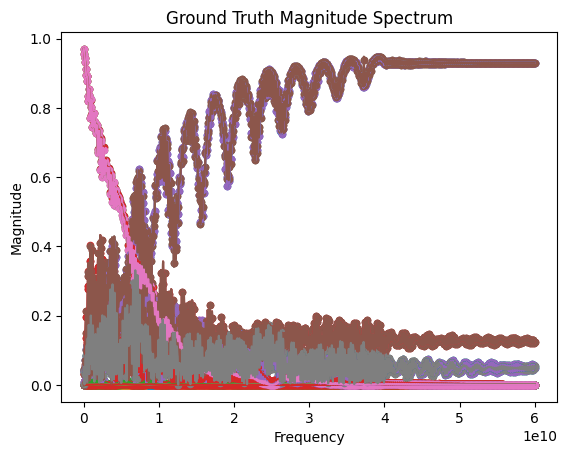

In [18]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x_mag[0, i].cpu(), label=str(i))
    plt.scatter(y_freqs.f, y_mag[0, i].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

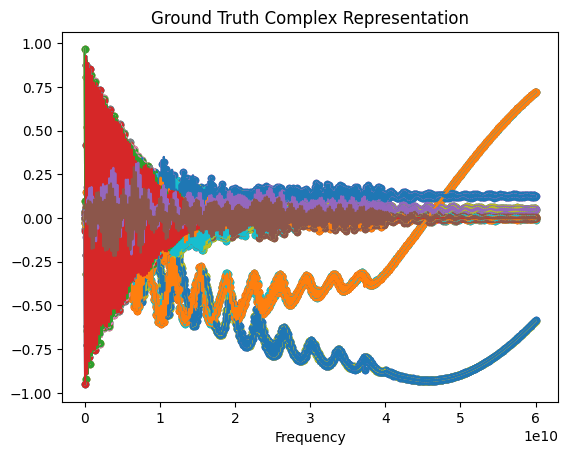

In [19]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(data_freqs.f, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(data_freqs.f, x[0,2*i+1].cpu(), label=str(i)+" Im")
    plt.scatter(y_freqs.f, y[0,2*i].cpu(), s=20)
    plt.scatter(y_freqs.f, y[0,2*i+1].cpu(), s=20)
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

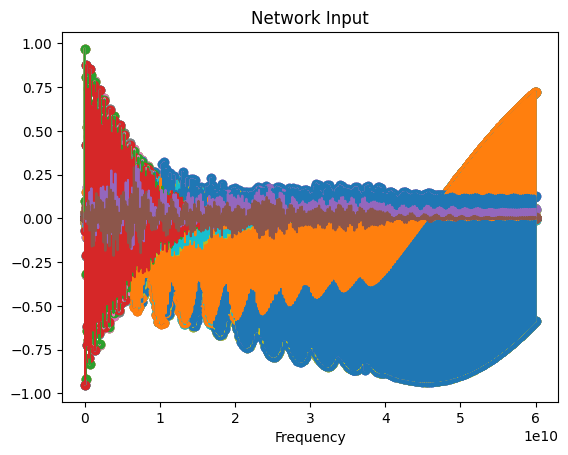

In [20]:
plt.figure()
for i in range(N_SPARAMS):
    plt.scatter(data_freqs.f, z[0,2*i].cpu())
    plt.scatter(data_freqs.f, z[0,2*i+1].cpu())
    plt.plot(data_freqs.f, z[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(data_freqs.f, z[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Network Input")
plt.xlabel("Frequency")
plt.show()

# 2. Network Setup

## Define network parameters

In [21]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 5

if NZ < 16:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 2) #third power of two after NZ 
elif NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NC = y.shape[1]

KERNEL_SIZE = 3
CAUSAL = True
PASSIVE = False

K = 1 #interpolation factor
NEW_CAUSAL = True

In [22]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("CAUSAL: ", CAUSAL)
print("PASSIVE: ", PASSIVE)
print("K: ", K)
print("NEW_CAUSAL", NEW_CAUSAL)

NZ:  156
NUM_LAYERS:  9
BASE NGF:  156
NC:  156
KERNEL_SIZE:  3
CAUSAL:  True
PASSIVE:  False
K:  1
NEW_CAUSAL True


## Init and check dimensions

In [23]:
from models import RESNET_BACKBONE, RESNET_HEAD, MODULAR_RESNET

net_backbone = RESNET_BACKBONE(ngf=BASE_NGF,
                               ngf_in_out=BASE_NGF,
                               kernel_size=KERNEL_SIZE,
                               num_layers=NUM_LAYERS)
net_head = RESNET_HEAD(nz=NZ,
                       ngf_in_out=BASE_NGF,
                       nc=NC,
                       output_size=N_FREQS,
                       kernel_size=KERNEL_SIZE,
                       causal=CAUSAL,
                       passive=PASSIVE,
                       k=K,
                       new_causality=NEW_CAUSAL)

net = MODULAR_RESNET(backbone=net_backbone,
                     head=net_head)
net = net.to(device)

In [24]:
z_temp = torch.randn((1, NZ, N_FREQS)).to(device)

test_out = net.forward(z_temp)

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 156, 9999])


In [25]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  4270968


## Define training parameters and run

In [26]:
LR = 2e-4 
NUM_ITER = 20000 

REG_HYPERPARAM = 1.0
REG_TYPE = "smoothing"
REG_TARGET = None #this is only sety if we are using centered_wd regularisation
REG_ORDER = 3
REG_NORM = 1

REDUCTION = "mean"

In [27]:
START_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9996546718755381


In [28]:
SGLD = True
BURN_IN_ITER = NUM_ITER - 5000
SAVE_OUTPUT_EVERY = 100

In [29]:
import Fitting

dip_args = {"y": y,
            "x": x,
            "z": z,
            "device": device,
            "model": net,
            "lr": LR,
            "num_iter": NUM_ITER,
            "reg_type": REG_TYPE,
            "reg_lambda": REG_HYPERPARAM,
            "reg_target": REG_TARGET,
            "reg_order": REG_ORDER,
            "reg_norm": REG_NORM,
            "reduction": REDUCTION,
            "kept_inds": kept_inds,
            "input_noise_start": START_NOISE_LEVEL,
            "input_noise_decay": NOISE_DECAY_FACTOR,
            "perturb_weights": SGLD,
            "burn_in_iter": BURN_IN_ITER,
            "save_output_every": SAVE_OUTPUT_EVERY,
            "debug": True}
dip_args = Fitting.dict2namespace(dip_args)

In [30]:
dip_results = Fitting.run_dip(dip_args)

  0%|          | 0/20000 [00:00<?, ?it/s]

# 3. Visualize and get metrics

In [31]:
print(dip_results.__dict__.keys())

dict_keys(['out_list', 'mse_list_gt', 'mse_list_meas', 'mse_list_mean_gt', 'mse_list_mean_meas', 'reg_list'])


In [32]:
print("Final MSE: %.2e" % dip_results.mse_list_gt[-1])
print("Final Mean MSE: %.2e" % dip_results.mse_list_mean_gt[-1])

Final MSE: 4.53e-05
Final Mean MSE: 4.14e-05


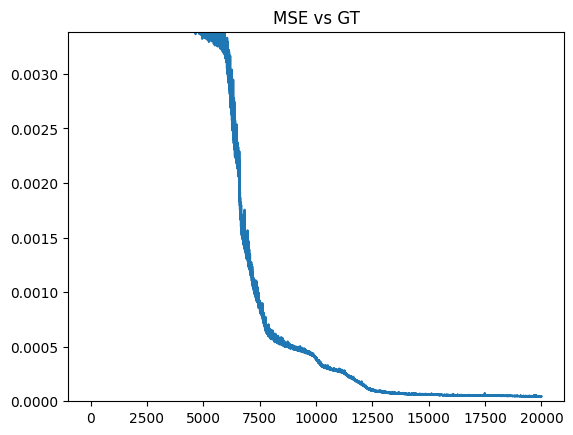

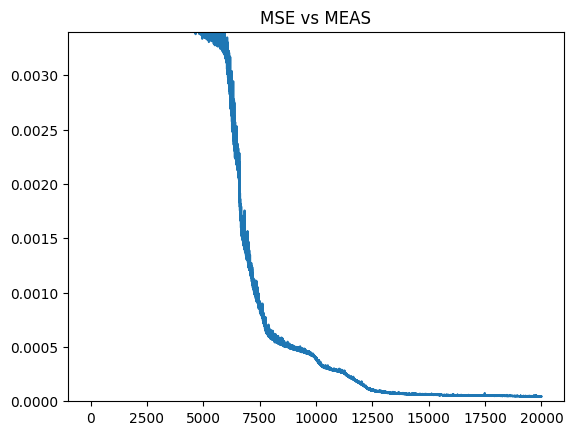

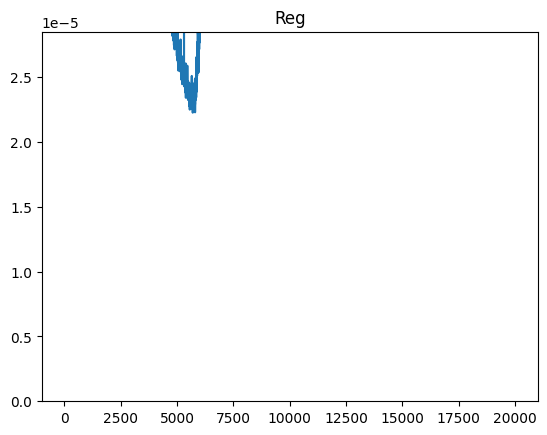

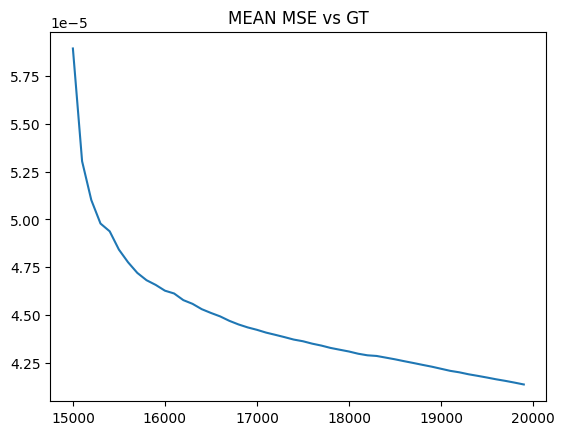

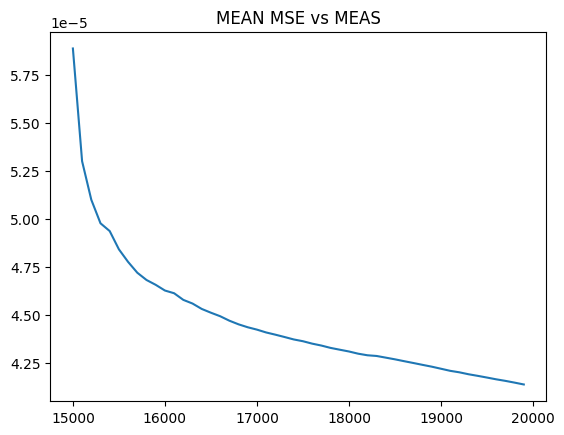

In [33]:
MAX_IDX = 5000

plt.figure()
plt.plot(dip_results.mse_list_gt)
plt.title("MSE vs GT")
plt.ylim(0, dip_results.mse_list_gt[MAX_IDX])
plt.show()

plt.figure()
plt.plot(dip_results.mse_list_meas)
plt.title("MSE vs MEAS")
plt.ylim(0, dip_results.mse_list_meas[MAX_IDX])
plt.show()

if hasattr(dip_results, "reg_list"):
    plt.figure()
    plt.plot(dip_results.reg_list)
    plt.title("Reg")
    plt.ylim(0, dip_results.reg_list[MAX_IDX])
    plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_gt)
plt.title("MEAN MSE vs GT")
plt.show()

plt.figure()
plt.plot(np.arange(BURN_IN_ITER, NUM_ITER, SAVE_OUTPUT_EVERY), dip_results.mse_list_mean_meas)
plt.title("MEAN MSE vs MEAS")
plt.show()

In [34]:
out_mag_list = [utils.sparams_to_mag(i) for i in dip_results.out_list]

mean_out_mag = torch.mean(torch.cat(out_mag_list), dim=0, keepdim=True)
std_out_mag = torch.std(torch.cat(out_mag_list), dim=0, keepdim=True)

In [35]:
last_out = dip_results.out_list[-1]

last_out_mag = utils.sparams_to_mag(last_out)

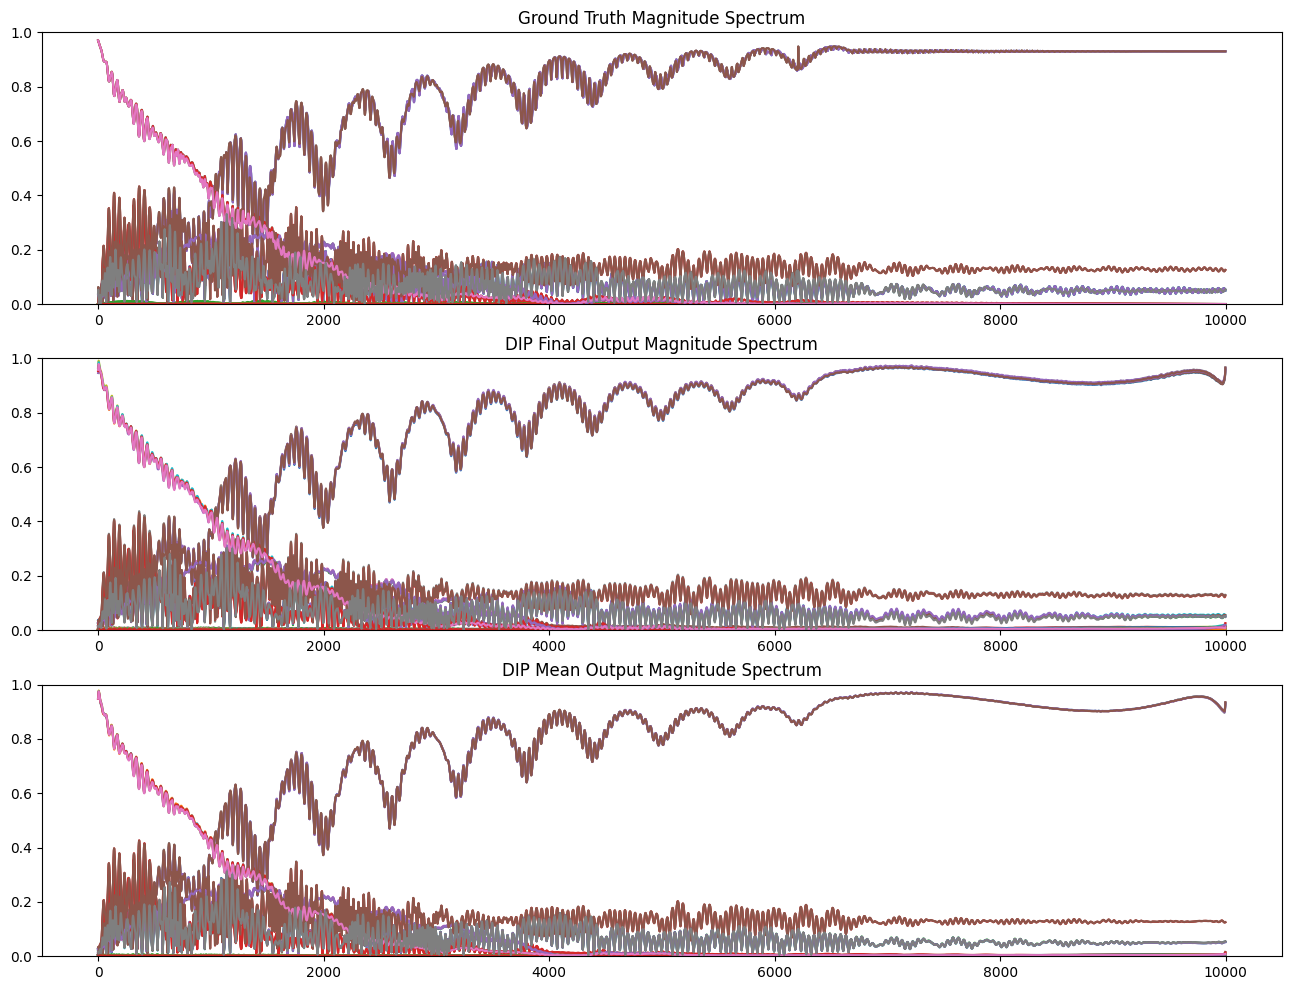

In [36]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[1].plot(last_out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Final Output Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(x_mag.shape[1]):
    axes[2].plot(mean_out_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Mean Output Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

Text(0.5, 1.0, 'Mean')

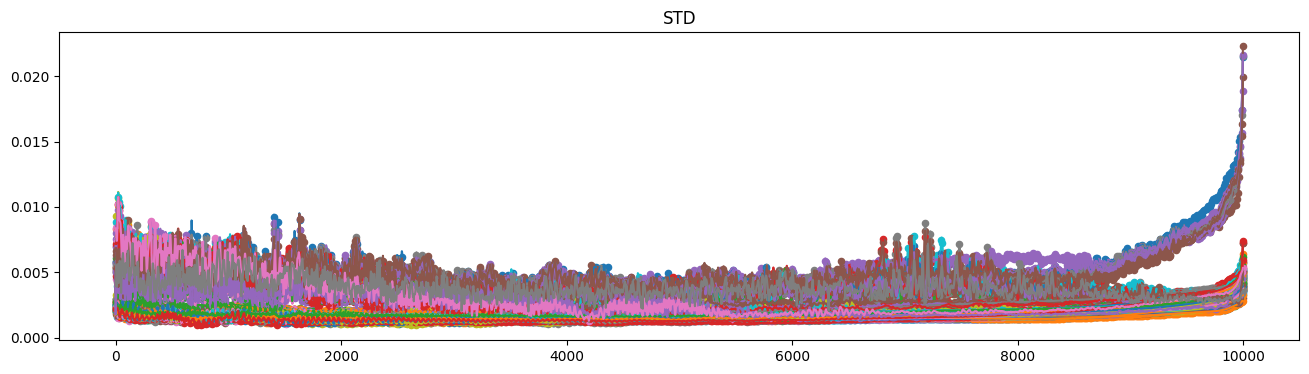

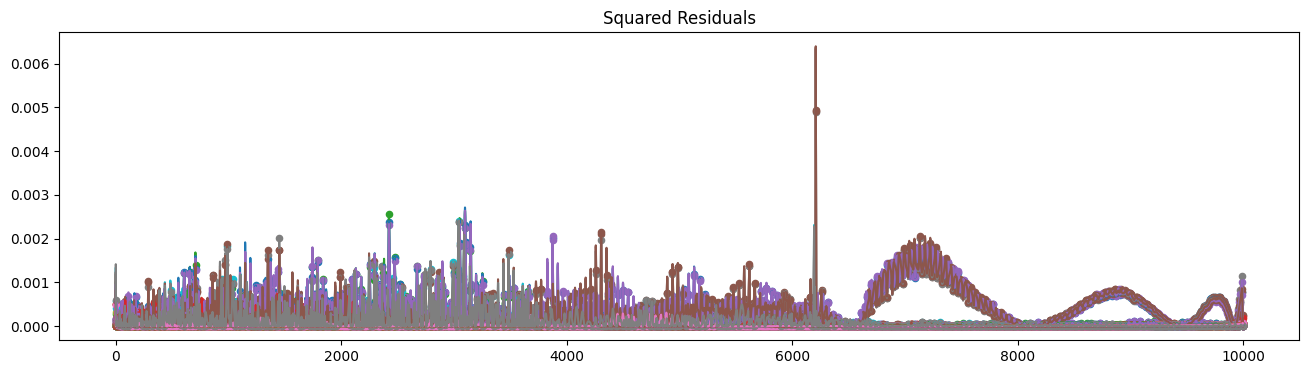

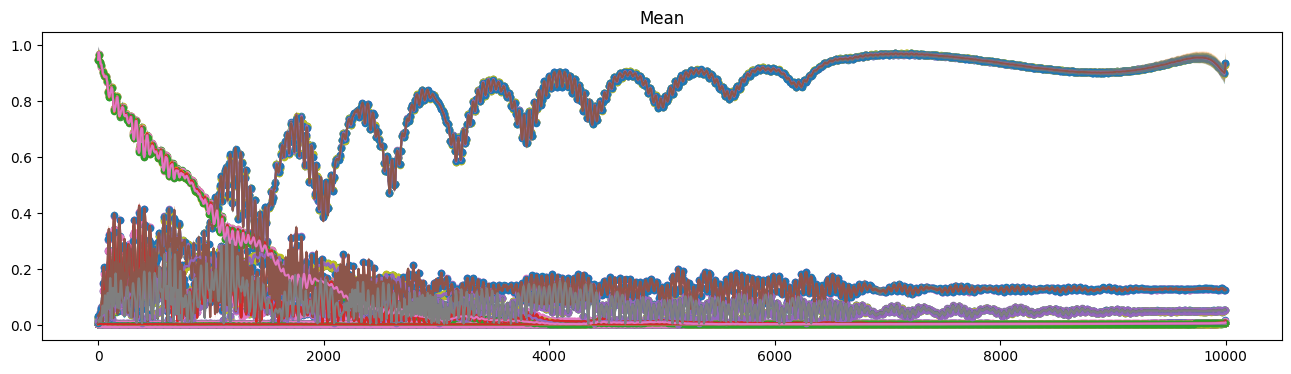

In [37]:
under_line = mean_out_mag - 1.96*std_out_mag
over_line = mean_out_mag + 1.96*std_out_mag

resid_mag = torch.square(x_mag - mean_out_mag)

plt.figure(figsize=(16,4))
for i in range(std_out_mag.shape[1]):
    plt.plot(std_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, std_out_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("STD")

plt.figure(figsize=(16,4))
for i in range(resid_mag.shape[1]):
    plt.plot(resid_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, resid_mag[0,i][kept_inds].detach().cpu(), s=20)
plt.title("Squared Residuals")

plt.figure(figsize=(16,4))
for i in range(mean_out_mag.shape[1]):
    plt.plot(np.arange(N_FREQS), mean_out_mag[0,i].detach().cpu(), label=str(i))
    plt.scatter(kept_inds, mean_out_mag[0,i][kept_inds].detach().cpu(), s=20)
    plt.fill_between(np.arange(N_FREQS), under_line[0,i].detach().cpu(), over_line[0,i].detach().cpu(), alpha=0.3)
plt.title("Mean")

# 4. Post-Processing and File Saving

## check PNSR of our raw outputs

In [38]:
mean_out = torch.mean(torch.cat(dip_results.out_list), dim=0, keepdim=True)

print(mean_out.shape)

torch.Size([1, 156, 9999])


In [39]:
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_mean = psnr(x.detach().cpu().numpy(), mean_out.detach().cpu().numpy())
psnr_last = psnr(x.detach().cpu().numpy(), last_out.detach().cpu().numpy())

print("PSNR (MEAN): ", psnr_mean)
print("PSNR (LAST): ", psnr_last)

PSNR (MEAN):  49.853306815339366
PSNR (LAST):  49.46395050942155


## Fit VF on the mean output and the measurements

### First make networks from the DIP outputs and measurements to use with VF 

In [40]:
last_out_matrix = utils.sparams_to_matrix(last_out)
mean_out_matrix = utils.sparams_to_matrix(mean_out)
meas_matrix = utils.sparams_to_matrix(y)

print(last_out_matrix.shape)
print(mean_out_matrix.shape)
print(meas_matrix.shape)

torch.Size([9999, 12, 12, 2])
torch.Size([9999, 12, 12, 2])
torch.Size([999, 12, 12, 2])


In [41]:
last_out_network = utils.matrix_to_network(last_out_matrix, data_freqs.f, "Last DIP Output for Chip "+str(CHIP_NUM))
mean_out_network = utils.matrix_to_network(mean_out_matrix, data_freqs.f, "Mean DIP Output for Chip "+str(CHIP_NUM))
meas_network = utils.matrix_to_network(meas_matrix, y_freqs.f, "Observations for Chip "+str(CHIP_NUM))

### Now fit the VF

In [42]:
from VF import vectorfit

fitter = vectorfit.VectorFitter(mean_out_network, number_of_failed_improvements_before_quit=5)
fitter_base = vectorfit.VectorFitter(meas_network, number_of_failed_improvements_before_quit=5)

In [43]:
vf_output = fitter.vector_fit("DIP Mean Output", data_freqs.f)

Performing fit with 1 poles.


/work2/04703/sravula/frontera/CurveFitting-DIP/VF/vectorfit.py:232: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 96.10571004170924 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 222.8725972045213 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 1.2323617399711917 vs 1.3324310518457656)
Performing fit with 3 poles.
  Fitting took 319.9022141965106 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 1.2137646842298435 vs 1.2323617399711917)
Performing fit with 4 poles.
  Fitting took 420.5975716067478 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 1.2128712307914336 vs 1.2137646842298435)
Performing fit with 5 poles.


KeyboardInterrupt: 

In [ ]:
vf_base_output = fitter_base.vector_fit("Measurements", data_freqs.f)
vf_base_output.fitted_network = vectorfit.VectorFitter.fill_fitted_network(data_freqs.f, vf_base_output.vector_fit_model)

In [ ]:
vf_out = network_to_sparams(vf_output.fitted_network)

print("vf_out shape: ", vf_out.shape)

In [ ]:
vf_out_base = network_to_sparams(vf_base_output.fitted_network)

print("vf_out_base shape: ", vf_out_base.shape)

In [ ]:
psnr_vf = psnr(x.detach().cpu().numpy(), vf_out.detach().cpu().numpy())
psnr_vf_base = psnr(x.detach().cpu().numpy(), vf_out_base.detach().cpu().numpy())

print("PSNR (VF): ", psnr_vf)
print("PSNR (VF BASELINE): ", psnr_vf_base)

In [ ]:
vf_mag = utils.sparams_to_mag(vf_out)
vf_mag_base = utils.sparams_to_mag(vf_out_base)

In [ ]:
_, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(x_mag.shape[1]):
    axes[0].plot(x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)

for i in range(vf_mag_base.shape[1]):
    axes[1].plot(vf_mag_base[0,i].detach().cpu(), label=str(i))
axes[1].set_title("VF Baseline Magnitude Spectrum")
axes[1].set_ylim(0,1)

for i in range(vf_mag.shape[1]):
    axes[2].plot(vf_mag[0,i].detach().cpu(), label=str(i))
axes[2].set_title("VF + DIP Magnitude Spectrum")
axes[2].set_ylim(0,1)

plt.show()

## Make networks and touchstone files 

### First write the GT data

In [44]:
import os

RESULTS_ROOT = "/tmp/dip_results"
write_path = os.path.join(RESULTS_ROOT, "CASE"+str(CHIP_NUM))

if not os.path.exists(write_path):
    os.makedirs(write_path)

In [45]:
data_net.write_touchstone(os.path.join(write_path, "GT"))

### Now Write the DIP and Measurement data

In [46]:
pct_string = str(int(np.round(100*M / N_FREQS))) + "_PCT"
print(pct_string)

write_path = os.path.join(write_path, pct_string)

if not os.path.exists(write_path):
    os.makedirs(write_path)

10_PCT


In [47]:
last_out_network.write_touchstone(os.path.join(write_path, "LAST_DIP"))
mean_out_network.write_touchstone(os.path.join(write_path, "MEAN_DIP"))
meas_network.write_touchstone(os.path.join(write_path, "MEASUREMENTS"))

### Finally Write the VF Data

In [ ]:
vf_output.fitted_network.write_touchstone(os.path.join(write_path, "VF_DIP"))
vf_base_output.fitted_network.write_touchstone(os.path.join(write_path, "VF"))

# 5. Check that the saved data look right when we open it back up